In [31]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import ternary
from ensemblecalibration.calibration.experiments import experiment_h0, experiment_h1

from ensemblecalibration.calibration.config import config_p_value_analysis
from ensemblecalibration.calibration.p_value_analysis import _simulation_pvals, npbe_test_p_values, npbe_test_v3_p_values, npbe_test_null_hypothesis
from ensemblecalibration.calibration.calibration_estimates import skceuq
from ensemblecalibration.calibration.calibration_estimates.distances import w1_distance, tv_distance, l2_distance, jensen_shannon_dist
from ensemblecalibration.calibration.calibration_estimates.helpers import calculate_pbar
from ensemblecalibration.sampling import sample_p_bar

### Compare different measures of distances on three dimensional compositional data

In [20]:
u_p = 10
u_q = 0.1

p_probs = np.random.dirichlet(u_p*np.ones(3), size=1000)
q_probs = np.random.dirichlet(u_q* np.ones(3), size=1000)

Text(0.5, 1.0, ' $p \\sim Dir((10, 10, 10))$, $q \\sim Dir((0.1, 0.1, 0.1))$')

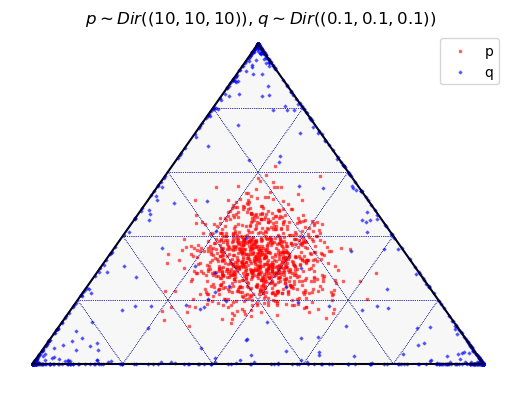

In [21]:
# ternary figure
fig, tax = ternary.figure(scale=1)
tax.boundary(linewidth=1.5)

tax.gridlines(color="black", multiple=.2, linewidth=.5)
tax.gridlines(color="blue", multiple=.2, linewidth=.5)

# Background color
tax.set_background_color(color="whitesmoke", alpha=0.7) # the detault, essentially
tax.scatter([tuple(p_probs[i]) for i in range(len(p_probs))], marker='s', color='red', s= 2, alpha=0.5, label='p')
tax.scatter([tuple(q_probs[i]) for i in range(len(q_probs))], marker='D', color='blue', s= 2, alpha=0.5, label='q')


tax.legend()

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

plt.title(f" $p \sim Dir({(u_p, u_p, u_p)})$, $q \sim Dir({(u_q, u_q, u_q)})$")


### analyse distances with respect to value of u

In [22]:
u = [0.01*n for n in range(1, 1000)]
dists_w1 = np.zeros(len(u))
dists_js = np.zeros(len(u))
dists_tv = np.zeros(len(u))

for i in tqdm(range(len(u))):
    u_q = u[i]
    p_probs = np.random.dirichlet(u_p*np.ones(3), size=100)
    q_probs = np.random.dirichlet(u_q* np.ones(3), size=100)
    dists_w1[i] = w1_distance(p_probs, q_probs)
    dists_js[i] = jensen_shannon_dist(p_probs, q_probs)
    dists_tv[i] = tv_distance(p_probs, q_probs)
    



100%|██████████| 999/999 [00:02<00:00, 368.72it/s]


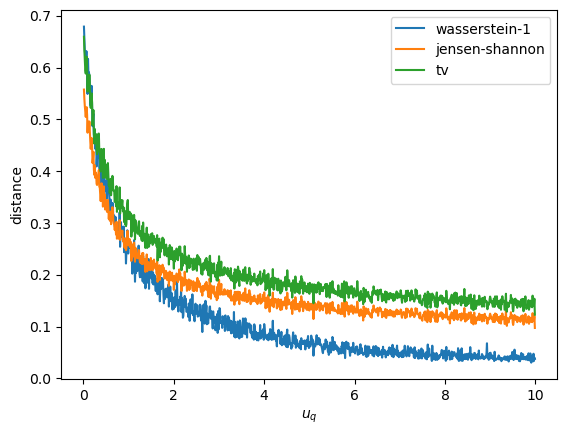

In [23]:
dists_w1

plt.plot(u, dists_w1, label='wasserstein-1')
plt.plot(u, dists_js, label='jensen-shannon')
plt.plot(u, dists_tv, label='tv')
plt.xlabel('$u_q$')
plt.ylabel('distance')
plt.legend()

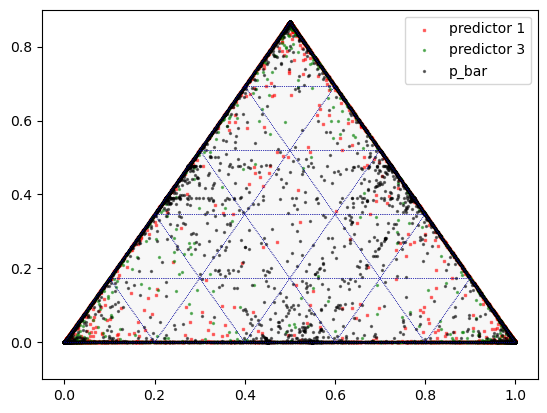

In [67]:
# evaluate experiments

p_probs, y_labels = experiment_h0(N=10000, M=2, K=3, u=10)
weights = np.random.dirichlet([1]*2)
# calculate p_bar
p_bar = calculate_pbar(weights_l=weights, P=p_probs, reshape=False, n_dims=1)
p_bar_2 = weights @ p_probs

# ternary figure
fig, tax = ternary.figure(scale=1)
tax.boundary(linewidth=1.5)

tax.gridlines(color="black", multiple=.2, linewidth=.5)
tax.gridlines(color="blue", multiple=.2, linewidth=.5)

# Background color
tax.set_background_color(color="whitesmoke", alpha=0.7) # the detault, essentially
tax.scatter([tuple(p_probs[:,1,:][i]) for i in range(len(p_probs))], marker='s', color='red', s= 2, alpha=0.5, label='predictor 1')
#tax.scatter([tuple(p_probs[:, 2,:][i]) for i in range(len(p_probs))], marker='D', color='blue', s= 2, alpha=0.5, label='predictor 2')
tax.scatter([tuple(p_probs[:, 0,:][i]) for i in range(len(p_probs))], marker='o', color='green', s= 2, alpha=0.5, label='predictor 3')

tax.scatter([tuple(p_bar[i]) for i in range(len(p_bar))], marker='o', color='black', s= 2, alpha=0.5, label='p_bar')
#tax.scatter([tuple(p_bar_2[i]) for i in range(len(p_bar_2))], marker='o', color='orange', s= 2, alpha=0.5, label='p_bar_2')


tax.legend()



### Analysis of the distribution of test statistics
sample randomly predictors from the convex hull, then perform statisstical boostrapping test. Compare value
of test statistc (miscalibration estimate) for the bootstrappping samples (wherer labels are generated under
the null hypothesis) with the value for the dataset.

In [3]:
# define test parameters
N_FEATURES = 100
N_ENS = 10
N_CLASSES = 10
U_DIR = 0.01


#### test for SKCEul under the null hypothesis:
generate probabilistic predictions of classifiers,
sample a random convex combination of them 
from whose predictions the labels are then sampled from (such that this convex comb is calibrated) 

In [13]:
p_probs, y_labels, weights_l = experiment_h0(N=N_FEATURES, M=N_ENS, K=N_CLASSES, u=U_DIR, 
                                             output_weights=True, l_prior=10)

stats, stats_h0, p_vals, true_stat = npbe_test_v3_p_values(p_probs=p_probs, y_labels=y_labels, 
                                                params=config_p_value_analysis["SKCEul"]["params"],
                                                weights_l=weights_l)

100%|██████████| 100/100 [15:22<00:00,  9.23s/it]


plot in histograms 

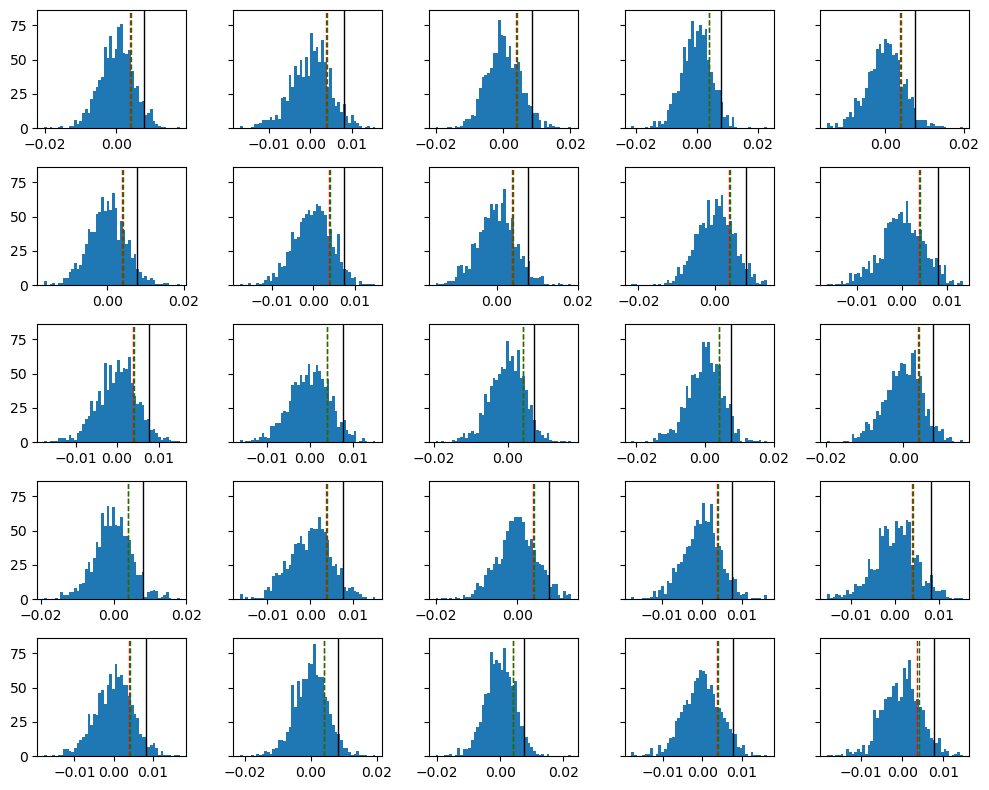

In [14]:
fig, ax = plt.subplots(5,5, figsize=(10,8), sharey=True)
count = 0
for i in range(5):
    for j in range(5):
        ax[i,j].hist(stats_h0[count, :], bins=50)
        ax[i,j].axvline(x=stats[count], ymin=0, color='r', linestyle='--', linewidth=1)
        # calculate 95 % quantile
        q = np.quantile(stats_h0[count, :], 0.95)
        ax[i, j].axvline(x=q, ymin=0, color='black', linewidth=1)
        ax[i,j].axvline(x=true_stat, color='g', linestyle='--', linewidth=1)
        count +=1
plt.tight_layout()

plot p values with respect to statistic of miscalibration measure in a scatter plot

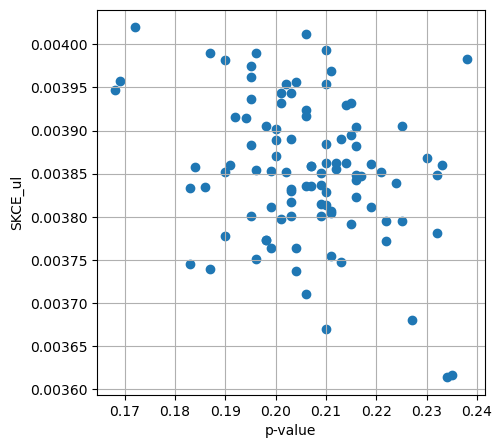

In [15]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(p_vals, stats)
ax.set_xlabel("p-value")
ax.set_ylabel("SKCE_ul")
plt.grid()

#### test for SKCEul under the alternative hypothesis: 

#### setting S3:

In [18]:
p_probs, y_labels= experiment_h1(N=N_FEATURES, M=N_ENS, K=N_CLASSES, u=U_DIR, random=True)

stats, stats_h0, p_vals = npbe_test_v3_p_values(p_probs=p_probs, y_labels=y_labels, 
                                                params=config_p_value_analysis["SKCEul"]["params"])

100%|██████████| 100/100 [15:34<00:00,  9.34s/it]


plot

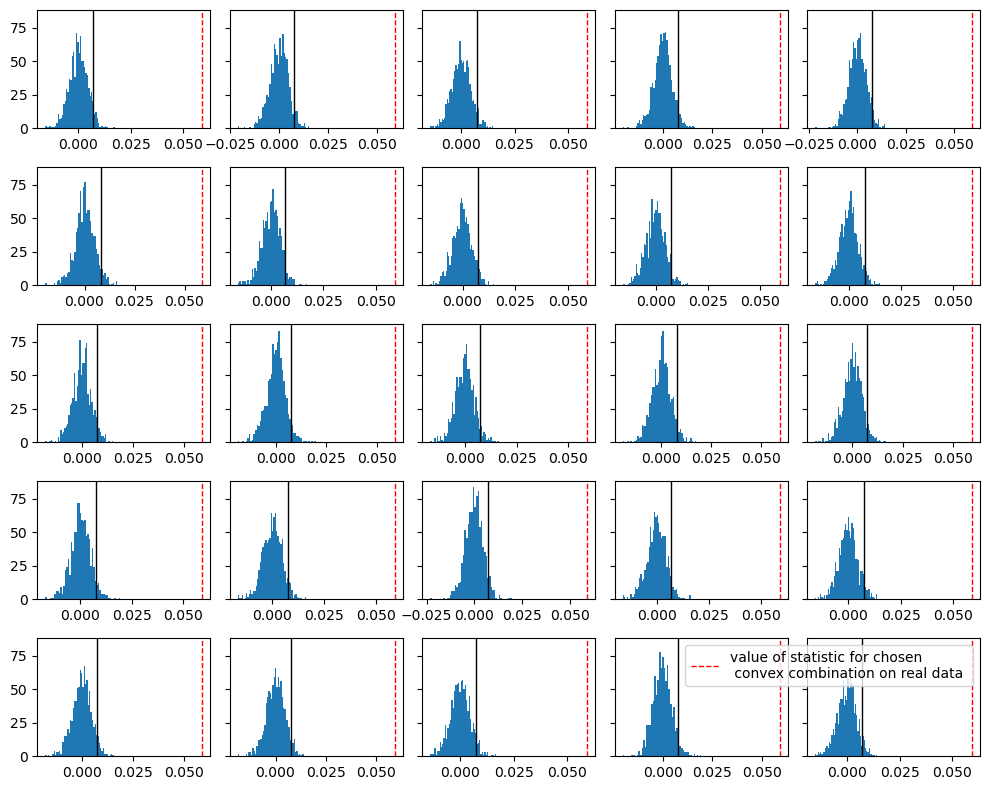

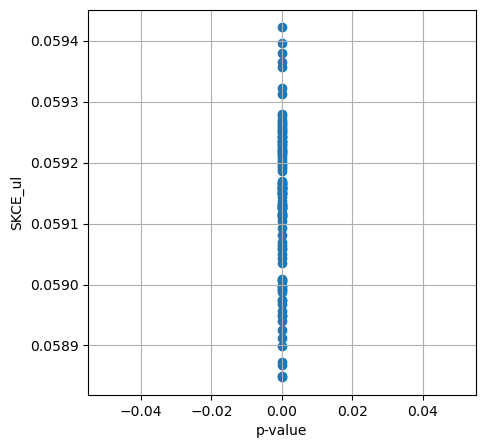

In [21]:
fig, ax = plt.subplots(5,5, figsize=(10,8), sharey=True)
count = 0
for i in range(5):
    for j in range(5):
        ax[i,j].hist(stats_h0[count, :], bins=50)
        ax[i,j].axvline(x=stats[count], ymin=0, color='r', linestyle='--', linewidth=1, 
                        label="value of statistic for chosen \n convex combination on real data ")
        # calculate 95 % quantile
        q = np.quantile(stats_h0[count, :], 0.95)
        ax[i, j].axvline(x=q, ymin=0, color='black', linewidth=1)
        #ax[i,j].axvline(x=true_stat, color='g', linestyle='--', linewidth=1)
        count +=1
plt.tight_layout()
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(p_vals, stats)
ax.set_xlabel("p-value")
ax.set_ylabel("SKCE_ul")
plt.grid()

#### setting S2:

In [20]:
p_probs, y_labels= experiment_h1(N=N_FEATURES, M=N_ENS, K=N_CLASSES, u=U_DIR, random=False)

stats, stats_h0, p_vals = npbe_test_v3_p_values(p_probs=p_probs, y_labels=y_labels, 
                                                params=config_p_value_analysis["SKCEul"]["params"])

100%|██████████| 100/100 [15:07<00:00,  9.07s/it]


plot:

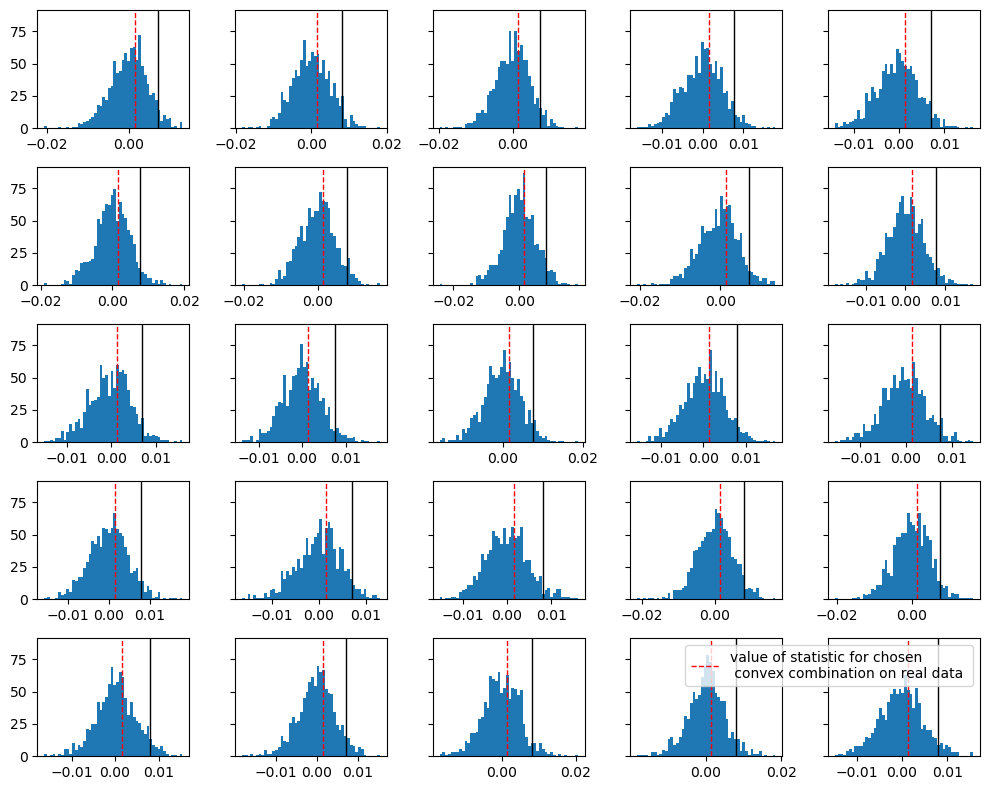

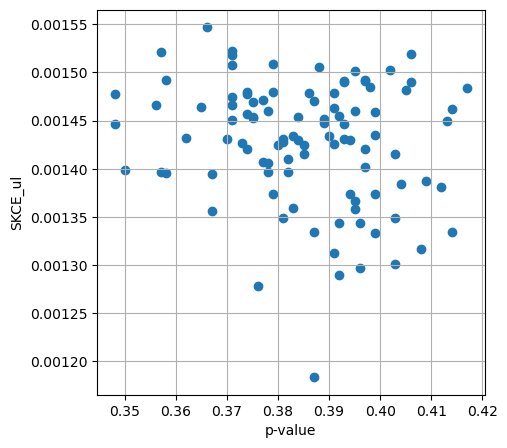

In [30]:
fig, ax = plt.subplots(5,5, figsize=(10,8), sharey=True)
count = 10
for i in range(5):
    for j in range(5):
        ax[i,j].hist(stats_h0[count, :], bins=50)
        ax[i,j].axvline(x=stats[count], ymin=0, color='r', linestyle='--', linewidth=1, 
                        label="value of statistic for chosen \n convex combination on real data ")
        # calculate 95 % quantile
        q = np.quantile(stats_h0[count, :], 0.95)
        ax[i, j].axvline(x=q, ymin=0, color='black', linewidth=1)
        #ax[i,j].axvline(x=true_stat, color='g', linestyle='--', linewidth=1)
        count +=1
plt.tight_layout()
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(p_vals, stats)
ax.set_xlabel("p-value")
ax.set_ylabel("SKCE_ul")
plt.grid()

In [27]:
avg_stats_h0 = np.mean(stats_h0, axis=0)
avg_stats = np.mean(stats)

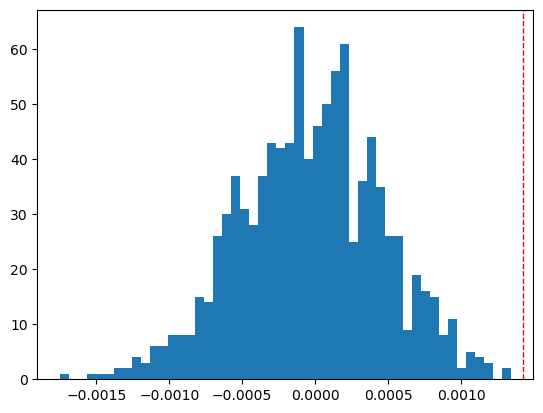

In [29]:
plt.hist(avg_stats_h0, bins=50)
plt.axvline(avg_stats, color='r', linestyle='--', linewidth=1)

### TODO: test for squared SKCEul!!

1. under null hypothesis

In [4]:
p_probs, y_labels, weights_l = experiment_h0(N=N_FEATURES, M=N_ENS, K=N_CLASSES, u=U_DIR, l_prior=1,
                                            output_weights=True)

stats, stats_h0, p_vals = npbe_test_v3_p_values(p_probs=p_probs, y_labels=y_labels, 
                                                params=config_p_value_analysis["SKCEul2"]["params"])

100%|██████████| 100/100 [15:25<00:00,  9.26s/it]


plot

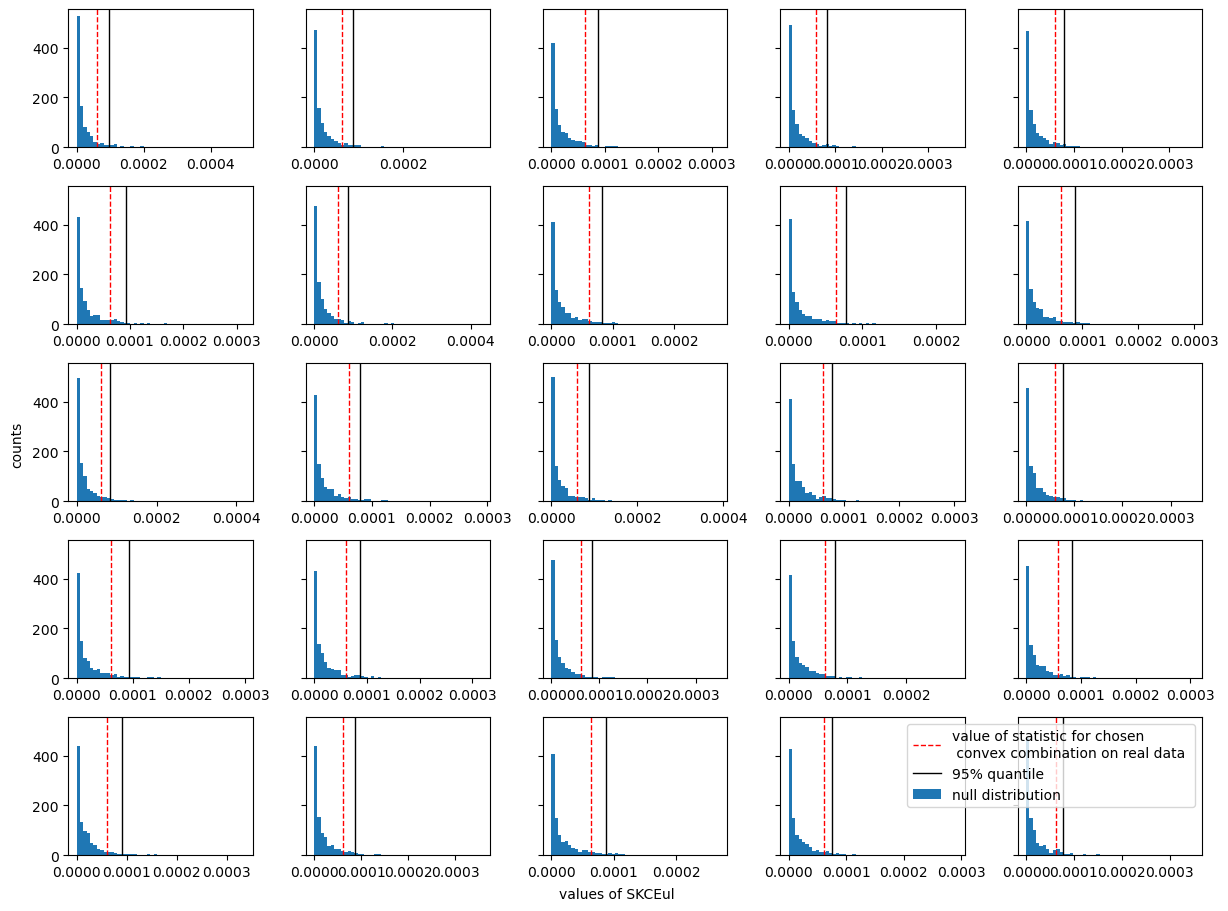

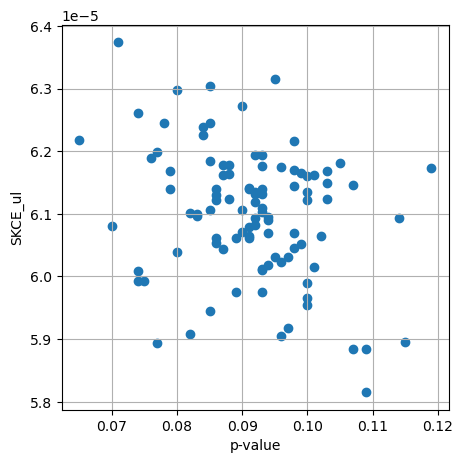

In [6]:
fig, ax = plt.subplots(5,5, figsize=(12,9), sharey=True)
count = 0
for i in range(5):
    for j in range(5):
        ax[i,j].hist(stats_h0[count, :], bins=50, label="null distribution")
        ax[i,j].axvline(x=stats[count], ymin=0, color='r', linestyle='--', linewidth=1,
                        label="value of statistic for chosen \n convex combination on real data ")
        # calculate 95 % quantile
        q = np.quantile(stats_h0[count, :], 0.95)
        ax[i, j].axvline(x=q, ymin=0, color='black', linewidth=1, label="95% quantile")
       # ax[i,j].axvline(x=true_stat, color='g', linestyle='--', linewidth=1)
        count +=1
plt.tight_layout()
plt.legend()
fig.text(0.5, 0.0, 'values of SKCEul', ha='center', va='center')
fig.text(0.0, 0.5, 'counts', ha='center', va='center', rotation='vertical')
plt.show()

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(p_vals, stats)
ax.set_xlabel("p-value")
ax.set_ylabel("SKCE_ul")
plt.grid()

analyse distribution of values of the test statistic for the real data for each convex combination

In [13]:
true_stat = config_p_value_analysis["SKCEul2"]["params"]["obj_lambda"](weights_l=weights_l,
                                                                                 p_probs=p_probs, 
                                                                            y_labels=y_labels,
                                                                            params=config_p_value_analysis["SKCEul2"]["params"])

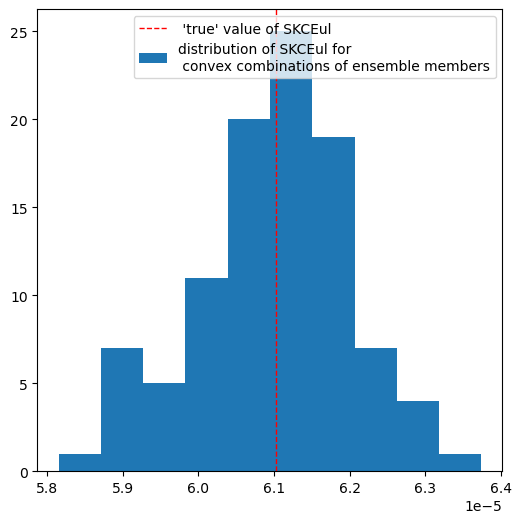

In [19]:
fig, ax = plt.subplots(figsize=(6,6))
ax.axvline(x=true_stat, color='r', linestyle='--', linewidth=1, label=" 'true' value of SKCEul")
ax.hist(stats, bins=10, label="distribution of SKCEul for \n convex combinations of ensemble members")
plt.legend()


under alternative:

In [32]:
p_probs, y_labels = experiment_h1(N=N_FEATURES, M=N_ENS, K=N_CLASSES, u=U_DIR)

stats, stats_h0, p_vals = npbe_test_v3_p_values(p_probs=p_probs, y_labels=y_labels, 
                                                params=config_p_value_analysis["SKCEul2"]["params"])

100%|██████████| 100/100 [15:12<00:00,  9.12s/it]


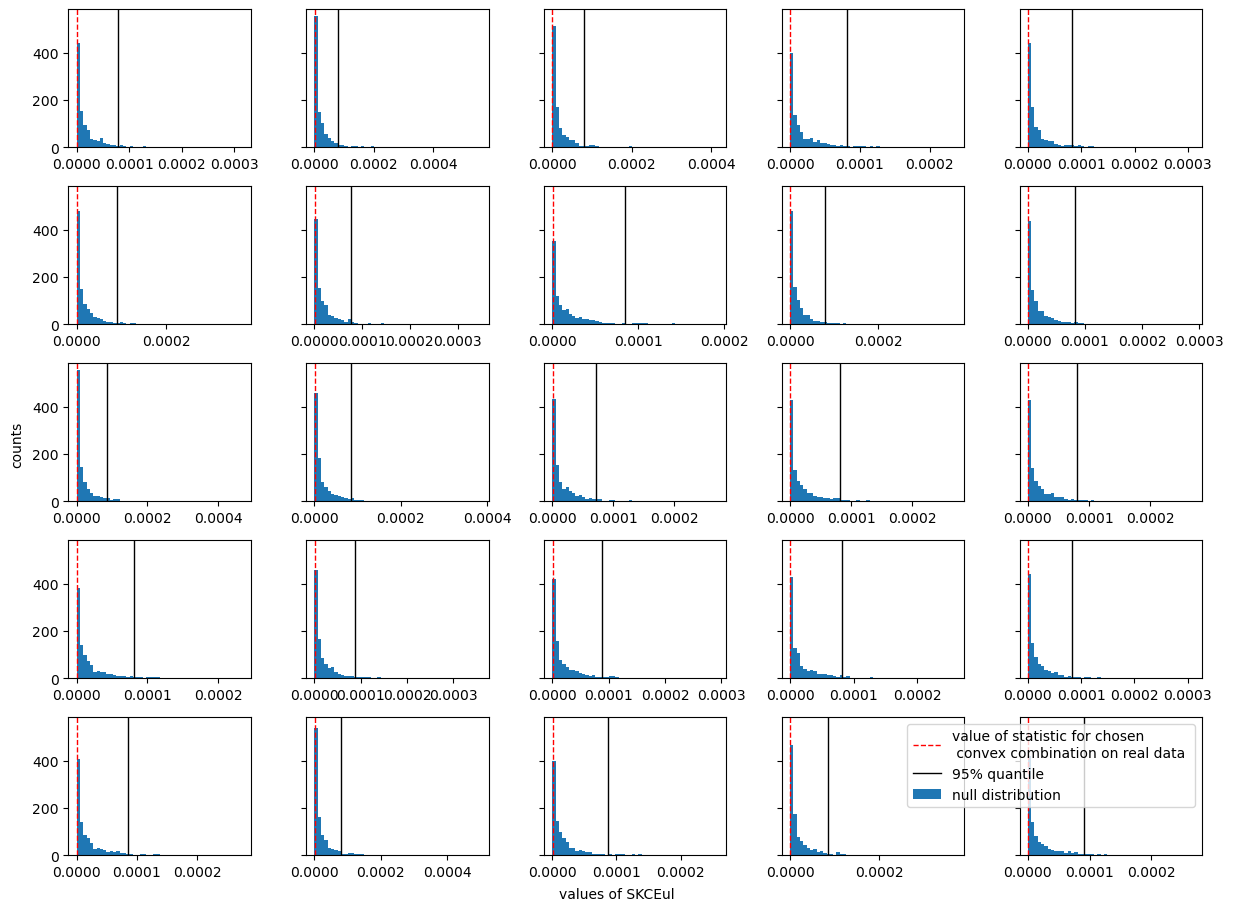

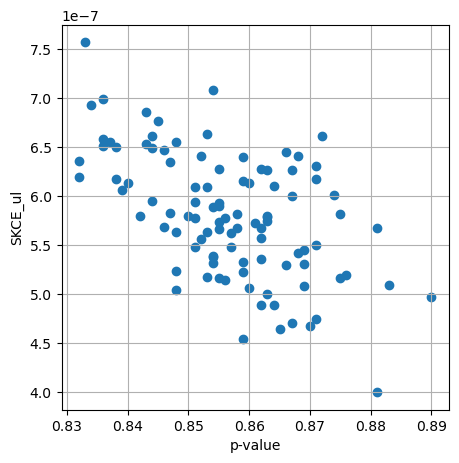

In [33]:
fig, ax = plt.subplots(5,5, figsize=(12,9), sharey=True)
count = 0
for i in range(5):
    for j in range(5):
        ax[i,j].hist(stats_h0[count, :], bins=50, label="null distribution")
        ax[i,j].axvline(x=stats[count], ymin=0, color='r', linestyle='--', linewidth=1,
                        label="value of statistic for chosen \n convex combination on real data ")
        # calculate 95 % quantile
        q = np.quantile(stats_h0[count, :], 0.95)
        ax[i, j].axvline(x=q, ymin=0, color='black', linewidth=1, label="95% quantile")
       # ax[i,j].axvline(x=true_stat, color='g', linestyle='--', linewidth=1)
        count +=1
plt.tight_layout()
plt.legend()
fig.text(0.5, 0.0, 'values of SKCEul', ha='center', va='center')
fig.text(0.0, 0.5, 'counts', ha='center', va='center', rotation='vertical')
plt.show()

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(p_vals, stats)
ax.set_xlabel("p-value")
ax.set_ylabel("SKCE_ul")
plt.grid()

In [34]:
p_probs, y_labels = experiment_h1(N=N_FEATURES, M=N_ENS, K=N_CLASSES, u=U_DIR, random=True)

stats, stats_h0, p_vals = npbe_test_v3_p_values(p_probs=p_probs, y_labels=y_labels, 
                                                params=config_p_value_analysis["SKCEul2"]["params"])

100%|██████████| 100/100 [15:06<00:00,  9.07s/it]


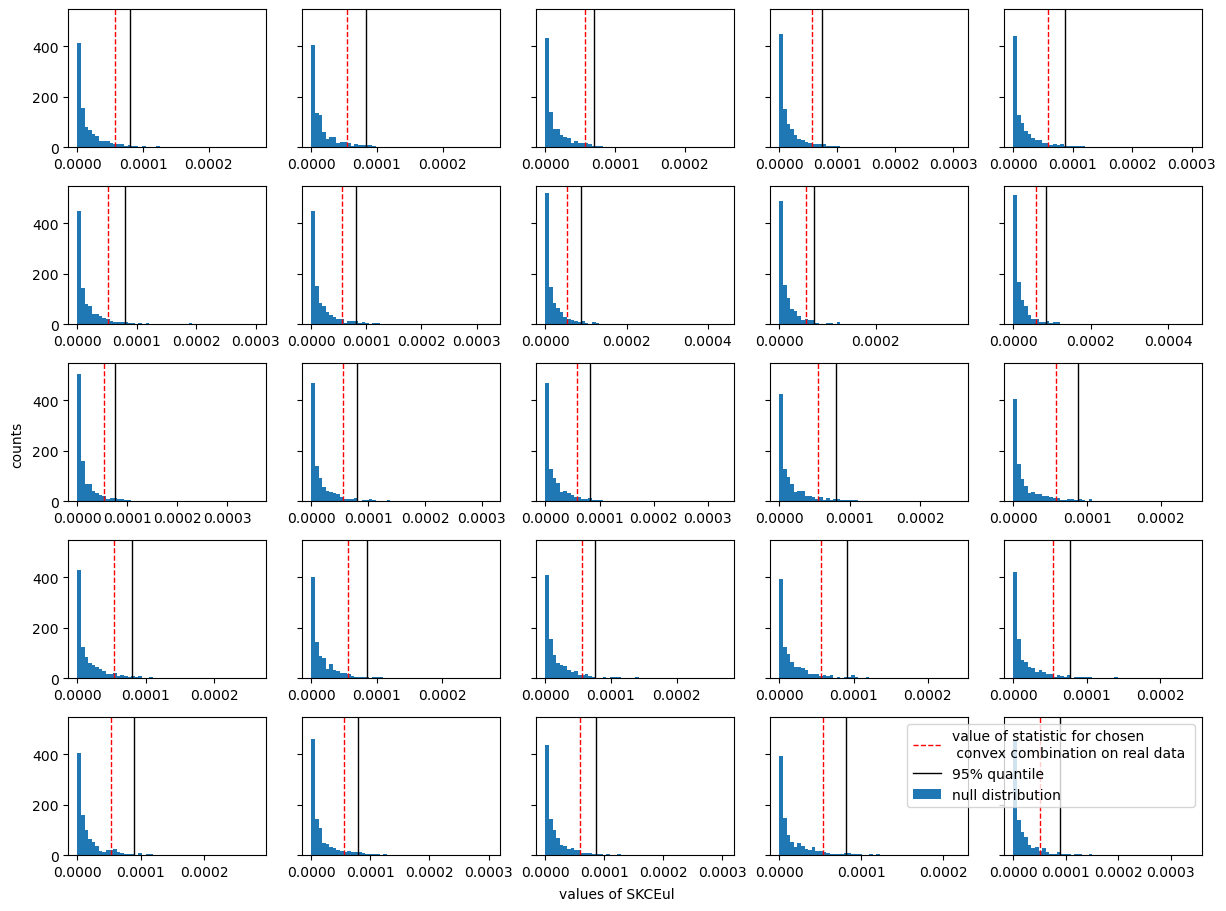

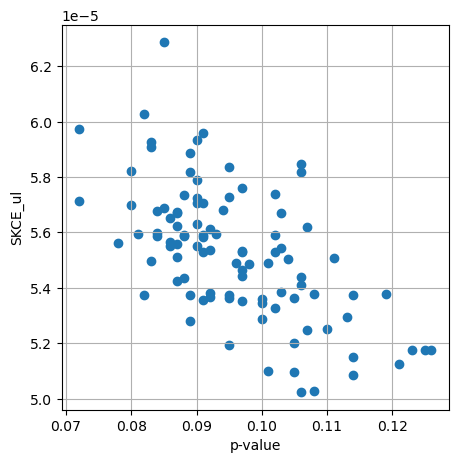

In [36]:
fig, ax = plt.subplots(5,5, figsize=(12,9), sharey=True)
count = 10
for i in range(5):
    for j in range(5):
        ax[i,j].hist(stats_h0[count, :], bins=50, label="null distribution")
        ax[i,j].axvline(x=stats[count], ymin=0, color='r', linestyle='--', linewidth=1,
                        label="value of statistic for chosen \n convex combination on real data ")
        # calculate 95 % quantile
        q = np.quantile(stats_h0[count, :], 0.95)
        ax[i, j].axvline(x=q, ymin=0, color='black', linewidth=1, label="95% quantile")
       # ax[i,j].axvline(x=true_stat, color='g', linestyle='--', linewidth=1)
        count +=1
plt.tight_layout()
plt.legend()
fig.text(0.5, 0.0, 'values of SKCEul', ha='center', va='center')
fig.text(0.0, 0.5, 'counts', ha='center', va='center', rotation='vertical')
plt.show()

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(p_vals, stats)
ax.set_xlabel("p-value")
ax.set_ylabel("SKCE_ul")
plt.grid()

Hosmer-Lemeshow:

In [37]:
p_probs, y_labels = experiment_h0(N=N_FEATURES, M=N_ENS, K=N_CLASSES, u=U_DIR)

stats, stats_h0, p_vals = npbe_test_v3_p_values(p_probs=p_probs, y_labels=y_labels, 
                                                params=config_p_value_analysis["HL10"]["params"])

  0%|          | 0/100 [00:00<?, ?it/s]/Users/mirajuergens/Library/CloudStorage/OneDrive-UGent/Code/EnsembleCalibration/ensemblecalibration/calibration/calibration_estimates/hl.py:60: RuntimeWarning: invalid value encountered in double_scalars
  dev_bk = ((o_bk-p_bk)**2)/p_bk
 31%|███       | 31/100 [04:58<11:06,  9.67s/it]/Users/mirajuergens/Library/CloudStorage/OneDrive-UGent/Code/EnsembleCalibration/ensemblecalibration/calibration/calibration_estimates/hl.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  dev_bk = ((o_bk-p_bk)**2)/p_bk
100%|██████████| 100/100 [16:03<00:00,  9.64s/it]


In [40]:
stats

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan])

## TODO!!
- analyze minimization for SKCE
- discrepancy minimum value of statistic vs "true" value of statistic for ECE, SKCEul, HL
- analysis for HL

test for ECE under null hypothesis:

In [17]:
p_probs, y_labels = experiment_h0(N=N_FEATURES, M=N_ENS, K=N_CLASSES, u=U_DIR, l_prior=1)

In [18]:
stats, stats_h0, p_vals = npbe_test_v3_p_values(p_probs=p_probs,y_labels=y_labels, params=config_p_value_analysis["ECEclass10"]["params"])

  0%|          | 0/100 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [7]:
p_vals

array([0.349, 0.345, 0.347, 0.362, 0.27 , 0.214, 0.269, 0.298, 0.311,
       0.298, 0.24 , 0.265, 0.276, 0.335, 0.305, 0.313, 0.319, 0.352,
       0.341, 0.173, 0.317, 0.37 , 0.201, 0.413, 0.331, 0.317, 0.311,
       0.365, 0.289, 0.266, 0.291, 0.268, 0.297, 0.374, 0.341, 0.444,
       0.273, 0.236, 0.378, 0.29 , 0.269, 0.238, 0.371, 0.317, 0.241,
       0.277, 0.244, 0.246, 0.359, 0.332, 0.288, 0.292, 0.314, 0.319,
       0.201, 0.176, 0.181, 0.209, 0.374, 0.247, 0.235, 0.354, 0.287,
       0.333, 0.299, 0.181, 0.314, 0.221, 0.366, 0.383, 0.332, 0.288,
       0.304, 0.179, 0.295, 0.274, 0.275, 0.386, 0.382, 0.284, 0.33 ,
       0.331, 0.336, 0.264, 0.238, 0.362, 0.168, 0.378, 0.294, 0.209,
       0.332, 0.306, 0.237, 0.359, 0.277, 0.276, 0.261, 0.381, 0.152,
       0.307])

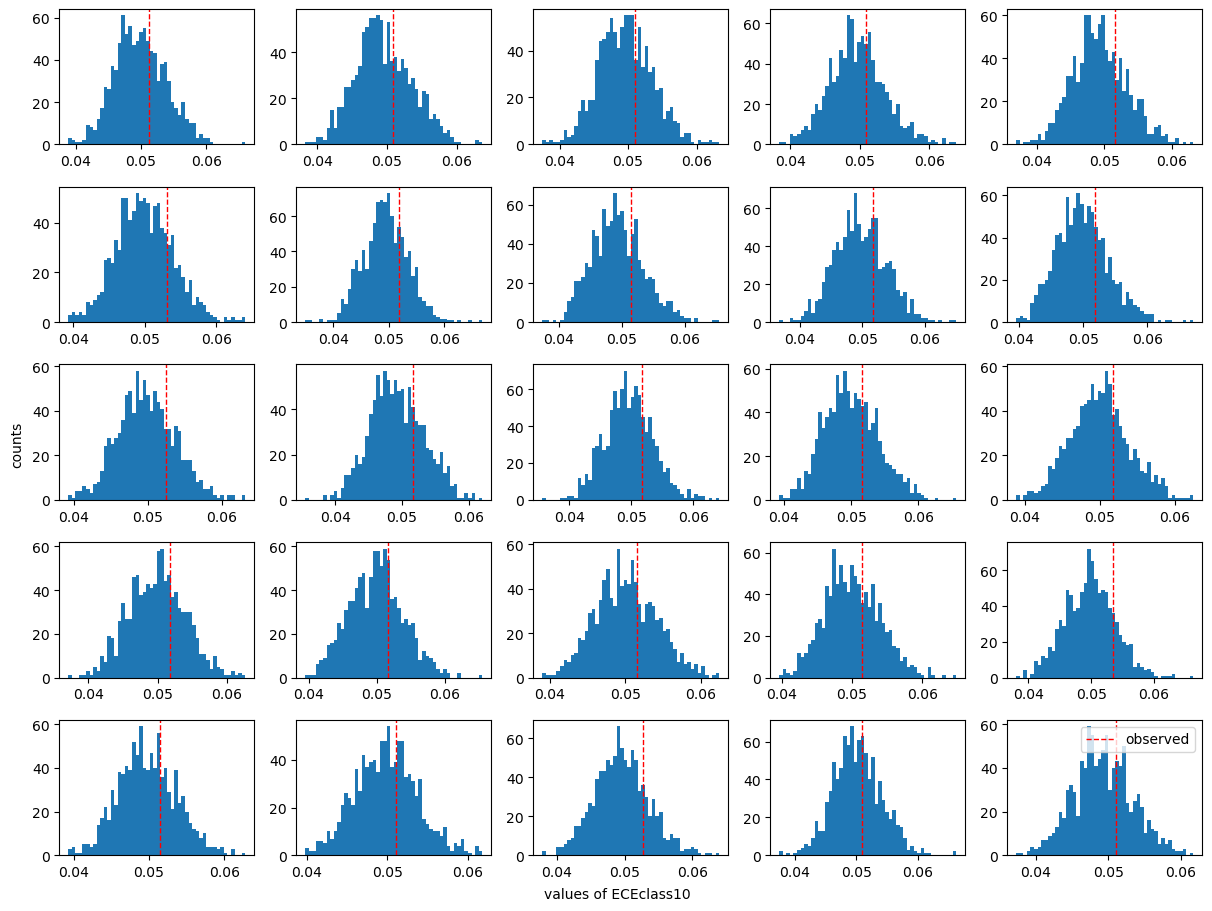

In [14]:
fig, ax = plt.subplots(5,5, figsize=(12,9),)
count = 0
for i in range(5):
    for j in range(5):
        ax[i,j].hist(stats_h0[count, :], bins=50)
        ax[i,j].axvline(x=stats[count], ymin=0, color='r', linestyle='--', linewidth=1, label="observed")
        count +=1
fig.text(0.5, 0.0, 'values of ECEclass10', ha='center', va='center')
fig.text(0.0, 0.5, 'counts', ha='center', va='center', rotation='vertical')
plt.tight_layout()
plt.legend()

plot the p values in dependency of the value of the statistic (miscalibration measure) in a scatter plot

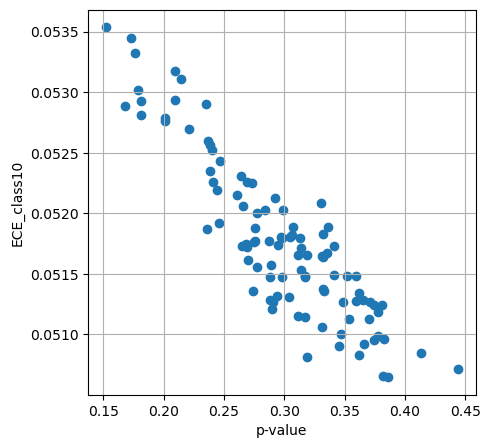

In [8]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(p_vals, stats)
ax.set_xlabel("p-value")
ax.set_ylabel("ECE_class10")
plt.grid()

test for ECE under alternative hypothesis:

In [19]:
p_probs, y_labels = experiment_h1(N=N_FEATURES, M=N_ENS, K=N_CLASSES, u=U_DIR)

In [20]:
stats, stats_h0, p_vals = npbe_test_v3_p_values(p_probs=p_probs,y_labels=y_labels,
                                                params=config_p_value_analysis["ECEclass10"]["params"])

100%|██████████| 100/100 [18:00<00:00, 10.80s/it]


In [23]:
stats

array([0.056839, 0.055487, 0.055306, 0.056648, 0.054754, 0.055973,
       0.054838, 0.056609, 0.055962, 0.05574 , 0.05689 , 0.054639,
       0.058135, 0.055788, 0.056927, 0.056105, 0.055302, 0.056748,
       0.055345, 0.056639, 0.055299, 0.055964, 0.055393, 0.055271,
       0.055563, 0.055161, 0.055364, 0.05661 , 0.056635, 0.055455,
       0.056195, 0.055271, 0.056809, 0.055358, 0.054625, 0.055915,
       0.056021, 0.055356, 0.05514 , 0.055298, 0.056895, 0.054371,
       0.056285, 0.054556, 0.054486, 0.055912, 0.056577, 0.05742 ,
       0.055323, 0.055959, 0.054545, 0.055884, 0.054562, 0.055951,
       0.056068, 0.05513 , 0.055586, 0.054586, 0.054546, 0.055998,
       0.055385, 0.057434, 0.05537 , 0.055969, 0.055449, 0.056101,
       0.056713, 0.056954, 0.056192, 0.055916, 0.05462 , 0.055833,
       0.05537 , 0.055925, 0.055444, 0.056044, 0.056911, 0.056007,
       0.056086, 0.055457, 0.055114, 0.056878, 0.055268, 0.056308,
       0.056328, 0.056688, 0.057033, 0.05546 , 0.055772, 0.055

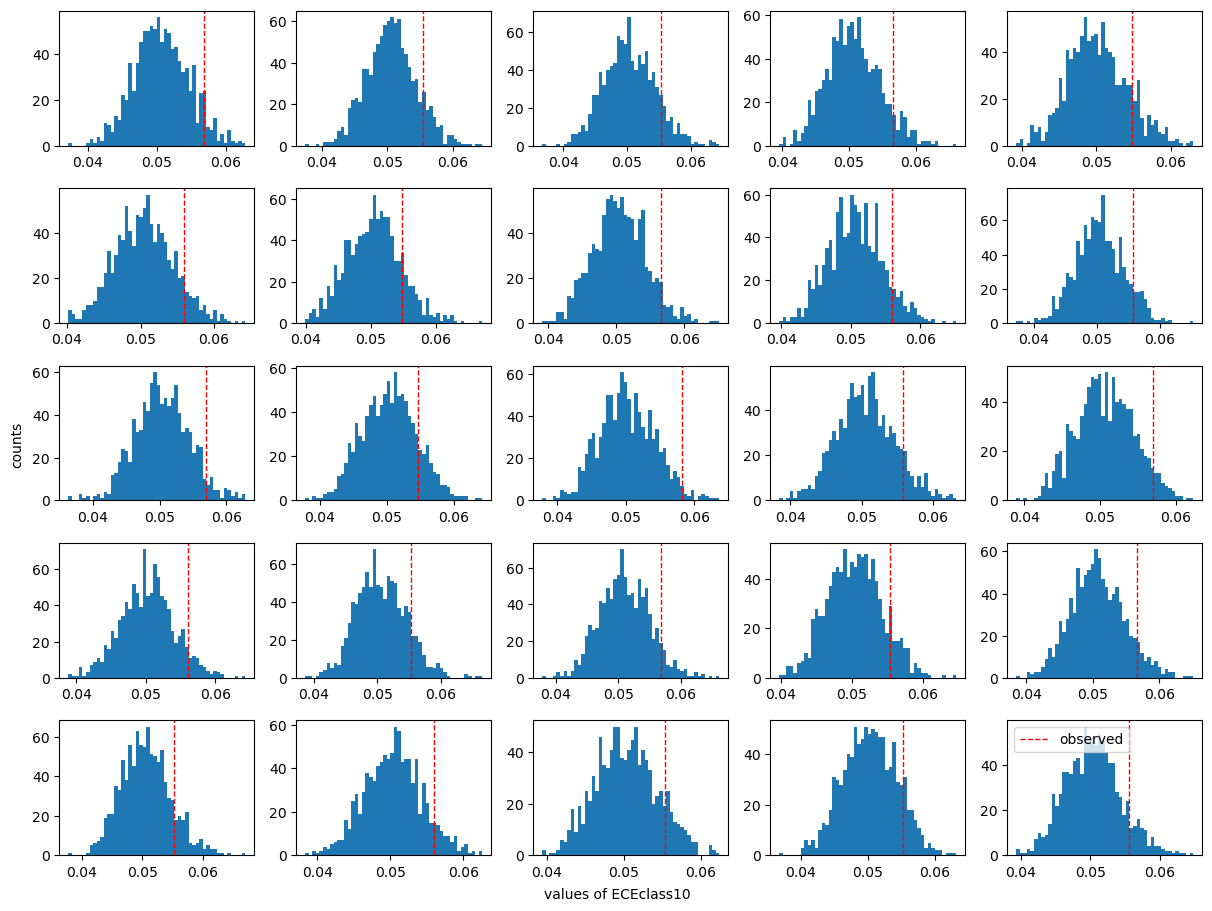

In [21]:
fig, ax = plt.subplots(5,5, figsize=(12,9),)
count = 0
for i in range(5):
    for j in range(5):
        ax[i,j].hist(stats_h0[count, :], bins=50)
        ax[i,j].axvline(x=stats[count], ymin=0, color='r', linestyle='--', linewidth=1, label="observed")
        count +=1
fig.text(0.5, 0.0, 'values of ECEclass10', ha='center', va='center')
fig.text(0.0, 0.5, 'counts', ha='center', va='center', rotation='vertical')
plt.tight_layout()
plt.legend()

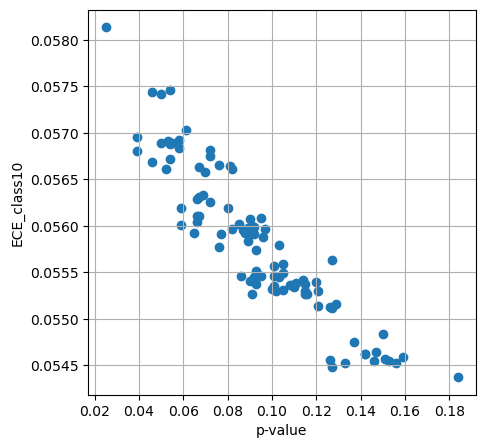

In [22]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(p_vals, stats)
ax.set_xlabel("p-value")
ax.set_ylabel("ECE_class10")
plt.grid()

### analyze distributions of miscalibration estimators

In this new setting, for each plot we re-sample the probabilistic predictions of the ensemble members,
and sample the distribution under the null hypothesis for a (randomly sampled) convex combination together
with the minimum value of the test statistic (where the minimum is taken over all possible c.c.'s)

#### 1. classwise ECE

In [4]:
p_probs, y_labels, weights_l = experiment_h0(N=N_FEATURES, M=N_ENS, K=N_CLASSES, u=U_DIR, l_prior=1, output_weights=True)
min_stat, p_val, stats = npbe_test_p_values(p_probs=p_probs, y_labels=y_labels,
                                                     params=config_p_value_analysis["ECEclass10"]["params"])
obj_val = config_p_value_analysis["ECEclass10"]["params"]["obj_lambda"](weight_l=weights_l, p_probs=p_probs, 
                                                                        y_labels=y_labels,
                                                                        params=config_p_value_analysis["ECEclass10"]["params"])

#### test for setting where $H_0$ is true: 

100%|██████████| 10/10 [01:58<00:00, 11.81s/it]


Text(0.0, 0.5, 'counts')

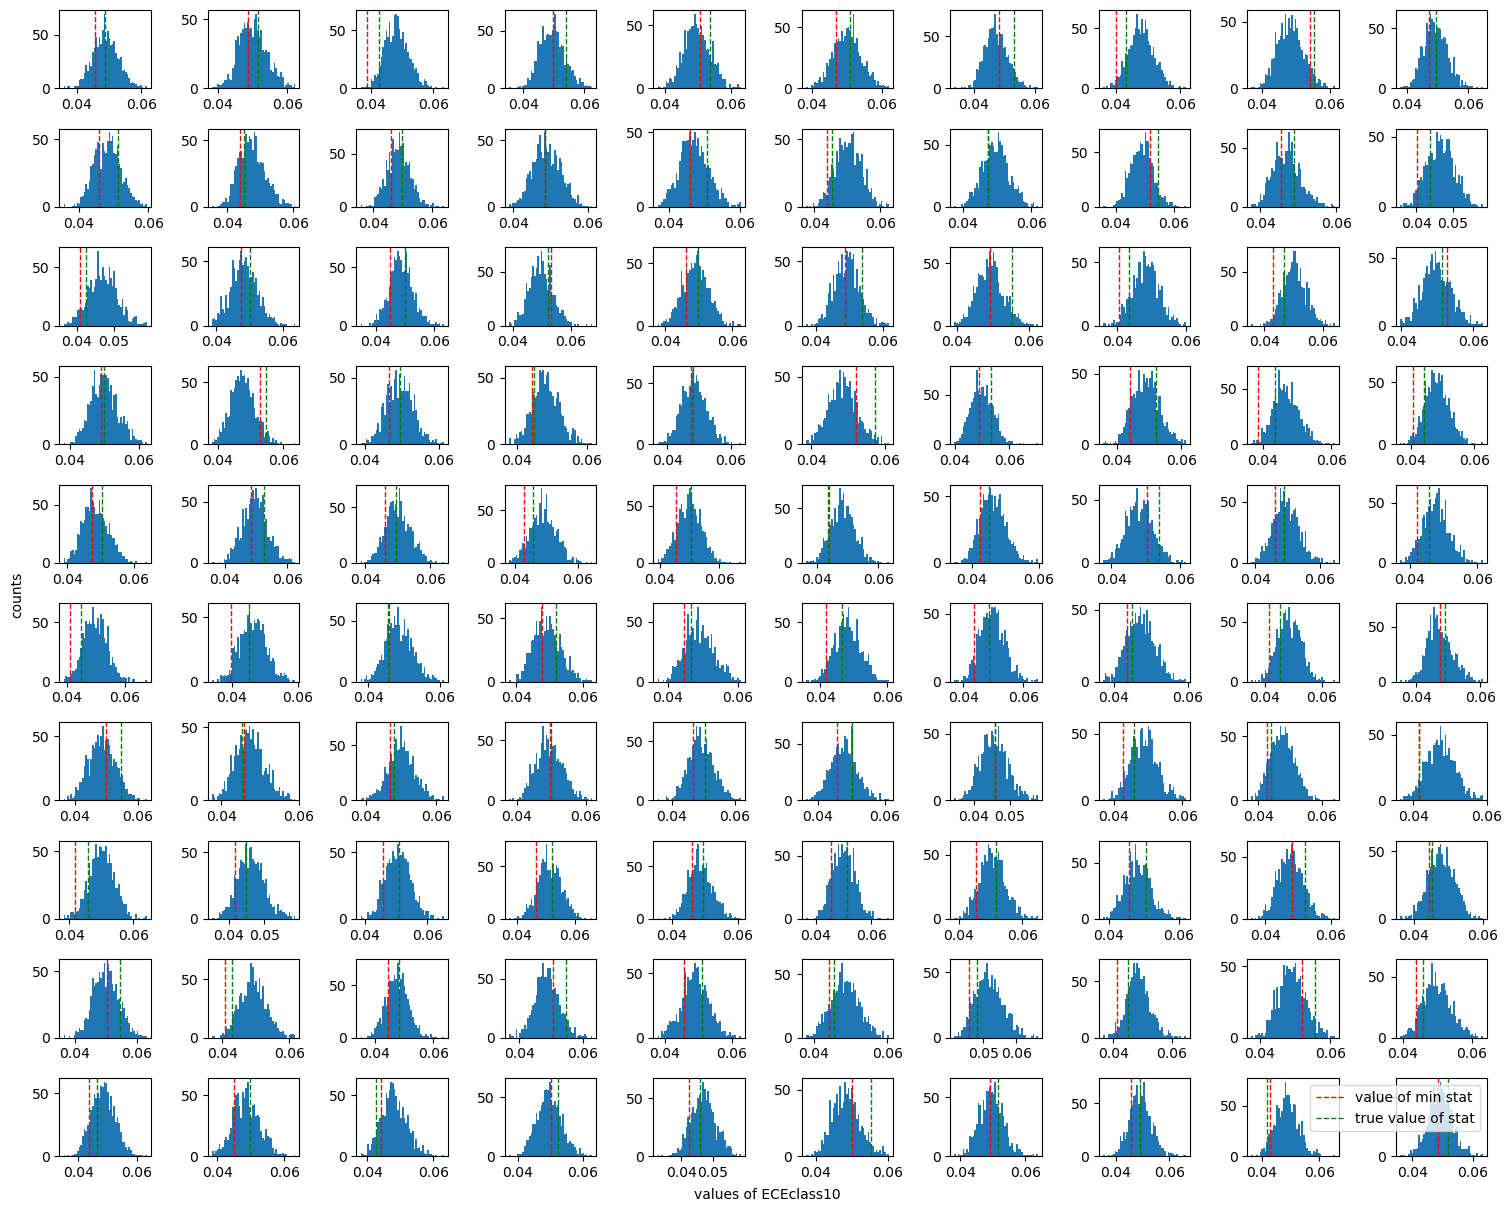

In [43]:
# save p-values
p_vals = []
# save minimum statistics
min_stats = []
true_stats = []

fig, ax = plt.subplots(10, 10, figsize=(15,12))
for i in range(10):
    for j in tqdm(range(10)):
        p_probs, y_labels, weights_l = experiment_h0(N=100, M=10, K=10, u=0.01, l_prior=10, 
                                                     output_weights=True)
        min_stat, p_val, stats = npbe_test_p_values(p_probs=p_probs, y_labels=y_labels,
                                                     params=config_p_value_analysis["ECEclass10"]["params"])
        p_vals.append(p_val)
        min_stats.append(min_stat)
        ax[i,j].hist(stats, bins=50)
        # check value of "truely calibrated" probabilistic classifier     
        obj_val = config_p_value_analysis["ECEclass10"]["params"]["obj_lambda"](weights_l=weights_l,
                                                                                 p_probs=p_probs, 
                                                                            y_labels=y_labels,
                                                                            params=config_p_value_analysis["ECEclass10"]["params"])
        true_stats.append(obj_val)     
        ax[i,j].axvline(x=min_stat, ymin=0, color='r', linestyle='--', linewidth=1,
                         label="value of min stat")
        ax[i,j].axvline(x=obj_val, ymin=0, color='g', linestyle='--', linewidth=1, 
                        label="true value of stat")
plt.tight_layout()
plt.legend()
fig.text(0.5, 0.0, 'values of ECEclass10', ha='center', va='center')
fig.text(0.0, 0.5, 'counts', ha='center', va='center', rotation='vertical')

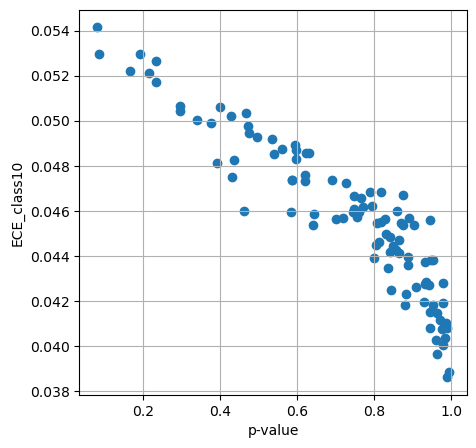

In [44]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(p_vals, min_stats)
ax.set_xlabel("p-value")
ax.set_ylabel("ECE_class10")
plt.grid()

(array([ 4.,  7.,  9., 11., 16., 25., 18.,  8.,  1.,  1.]),
 array([-0.00160973, -0.00064229,  0.00032514,  0.00129258,  0.00226001,
         0.00322745,  0.00419488,  0.00516231,  0.00612975,  0.00709718,
         0.00806462]),
 <a list of 10 Patch objects>)

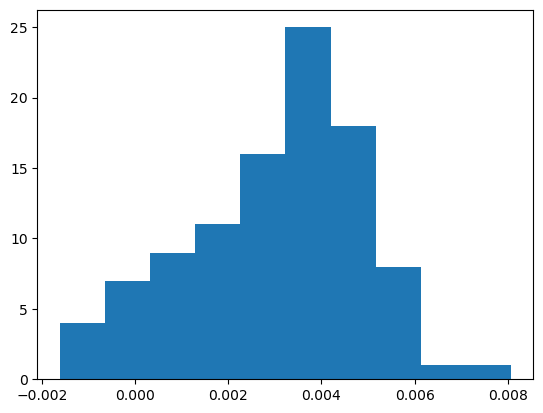

In [48]:
difs = np.array(true_stats) - np.array(min_stats)
plt.hist(difs)

now for setting where null hypothesis is not true

100%|██████████| 5/5 [01:00<00:00, 12.05s/it]


Text(0.0, 0.5, 'counts')

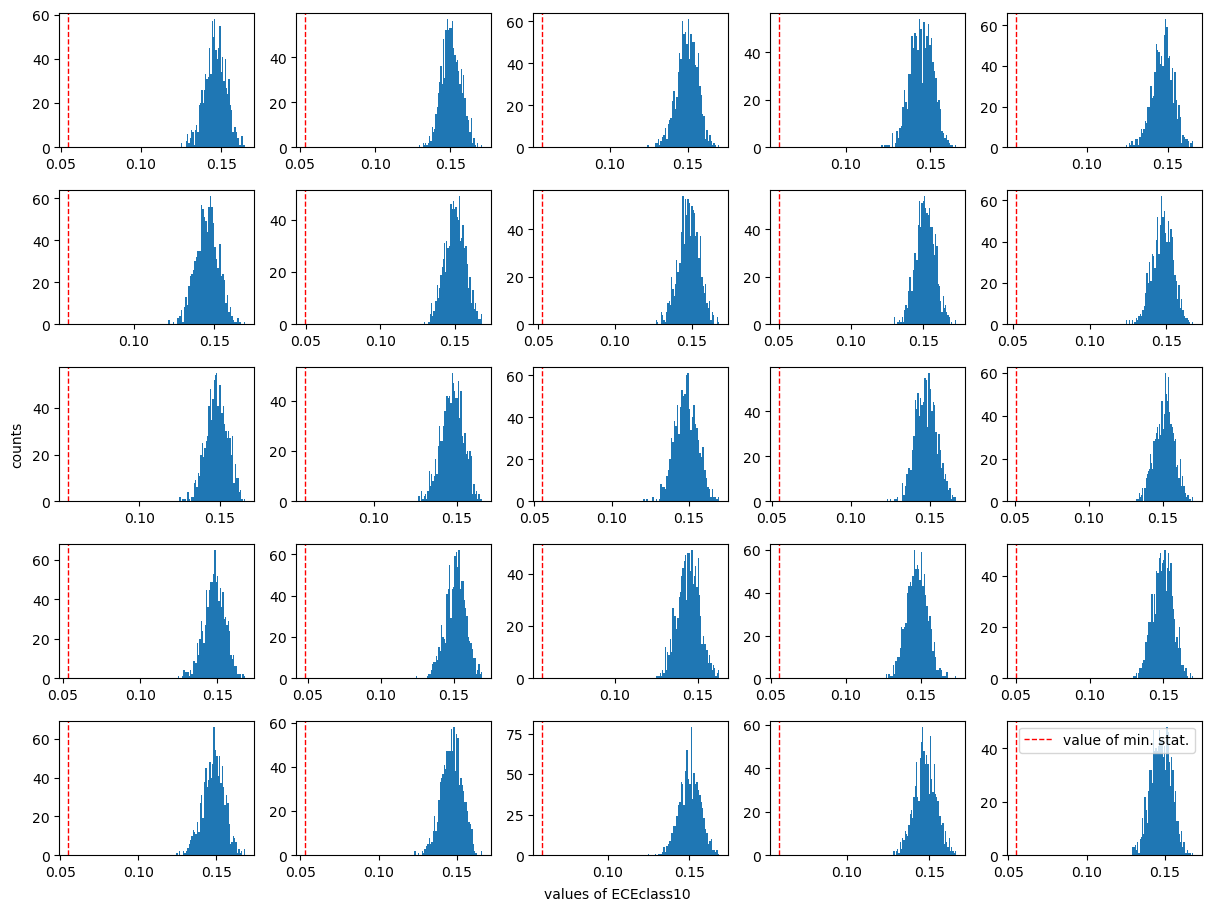

In [13]:
# save p-values
p_vals = []
# save minimum statistics
min_stats = []

fig, ax = plt.subplots(5, 5, figsize=(12,9))
for i in range(5):
    for j in tqdm(range(5)):
        p_probs, y_labels = experiment_h1(N=100, M=10, K=10, u=0.01)
        min_stat, p_val, stats = npbe_test_p_values(p_probs=p_probs, y_labels=y_labels,
                                                     params=config_p_value_analysis["ECEclass10"]["params"])
        p_vals.append(p_val)
        min_stats.append(min_stat)
        ax[i,j].hist(stats, bins=50)
        ax[i,j].axvline(x=min_stat, ymin=0, color='r', linestyle='--', linewidth=1, 
                        label="value of min. stat.")            
plt.tight_layout()
plt.legend()
fig.text(0.5, 0.0, 'values of ECEclass10', ha='center', va='center')
fig.text(0.0, 0.5, 'counts', ha='center', va='center', rotation='vertical')

#### 2. SKCE

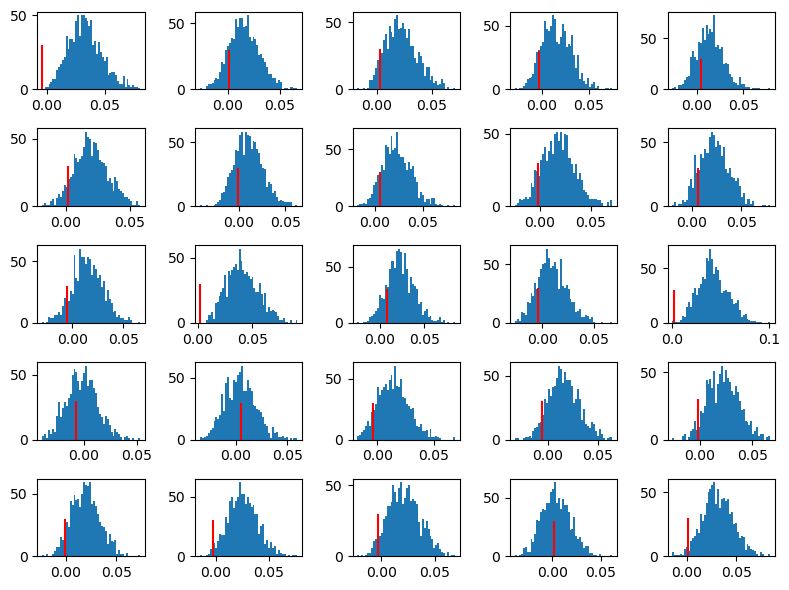

In [2]:
fig, ax = plt.subplots(5, 5, figsize=(8,6))
for i in tqdm(range(5)):
    for j in range(5):
        p_probs, y_labels = experiment_h0(N=100, M=10, K=10, u=0.01, l_prior=10)
        min_stat, p_vals, stats = npbe_test_p_values(p_probs=p_probs, y_labels=y_labels, params=config_p_value_analysis["SKCEul"]["params"])
        ax[i,j].hist(stats, bins=50)
        ax[i,j].axvline(x=min_stat, ymin=0, colors='r', linestyle='--', linewidth=1)
plt.tight_layout()

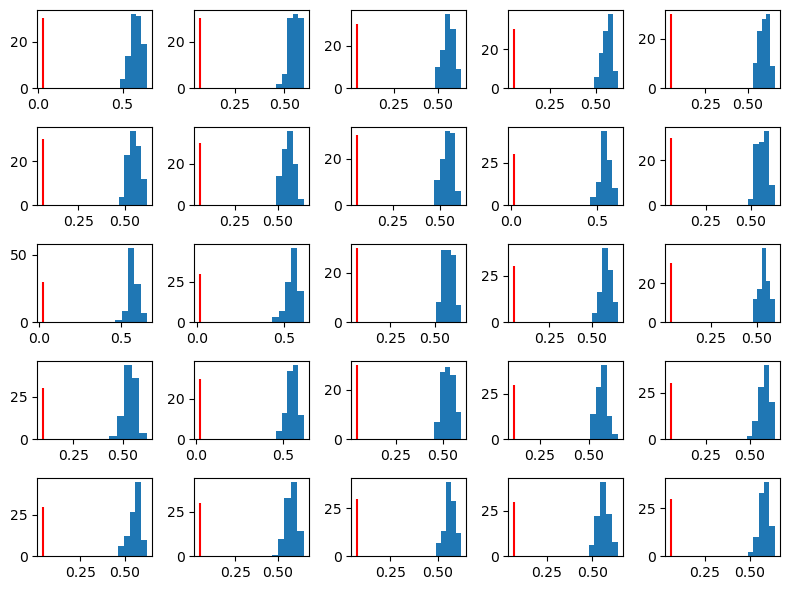

In [3]:
fig, ax = plt.subplots(5, 5, figsize=(8,6))
for i in range(5):
    for j in range(5):
        p_probs, y_labels = experiment_h0(N=100, M=10, K=10, u=0.01, l_prior=10)
        min_stat, p_vals, stats = npbe_test_p_values(p_probs=p_probs, y_labels=y_labels, params=config_p_value_analysis["ECEconf5"]["params"])
        ax[i,j].hist(stats, bins=5)
        ax[i,j].vlines(x=min_stat, ymin=0, ymax=30, colors='r')
plt.tight_layout()

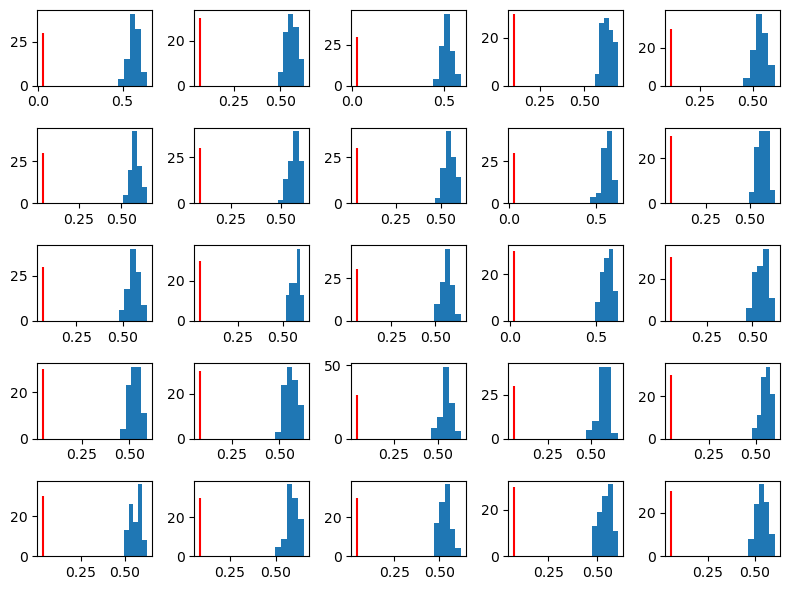

In [3]:
fig, ax = plt.subplots(5, 5, figsize=(8,6))
for i in range(5):
    for j in range(5):
        p_probs, y_labels = experiment_h0(N=100, M=10, K=10, u=0.01, l_prior=10)
        min_stat, p_vals, stats = npbe_test_p_values(p_probs=p_probs, y_labels=y_labels, params=config_p_value_analysis["ECEconf5"]["params"])
        ax[i,j].hist(stats, bins=5)
        ax[i,j].vlines(x=min_stat, ymin=0, ymax=30, colors='r')
plt.tight_layout()

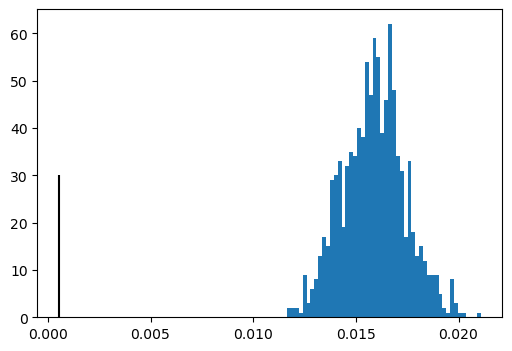

In [3]:
min_stat, p_vals, stats = npbe_test_p_values(p_probs=p_probs, y_labels=y_labels, params=config_p_value_analysis["SKCEuq"]["params"])

fig, ax = plt.subplots(figsize=(6,4))
ax.hist(stats, bins=50)
ax.vlines(x=min_stat, ymin=0, ymax=30)

### p-value Analysis to visualize correlation between p-value and value of statistic

In [11]:
result_skceuq = _simulation_pvals(tests=config_p_value_analysis, N=100, M=10, K=10, R=5, u=0.01, experiment=experiment_h0)

  0%|          | 0/5 [00:00<?, ?it/s]


KeyError: 'test'

In [5]:
result_skceuq

{'SKCEul': array([[ 8.83750422e-03,  2.84251385e-03,  7.49812738e-03,
          8.79483859e-04, -9.53990947e-03],
        [ 4.26000000e-01,  9.68000000e-01,  6.36000000e-01,
          9.20000000e-01,  8.43000000e-01]]),
 'HL5': array([[22.3566091 , 37.91172056, 27.28180728, 16.19859839, 21.80542646],
        [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ]]),
 'HL10': array([[37.70746078, 58.83520921, 47.27653128, 31.86675393, 47.1253145 ],
        [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ]]),
 'ECEconf5': array([[0.01707399, 0.06912498, 0.07252361, 0.0672907 , 0.03688081],
        [1.        , 1.        , 1.        , 1.        , 1.        ]]),
 'ECEconf10': array([[0.02484596, 0.08136251, 0.08355506, 0.11684673, 0.05215653],
        [1.        , 1.        , 1.        , 1.        , 1.        ]]),
 'ECEclass5': array([[0.03359214, 0.04055606, 0.03441673, 0.03739249, 0.04431871],
        [1.        , 1.        , 1.        , 1.        , 1.        ]]

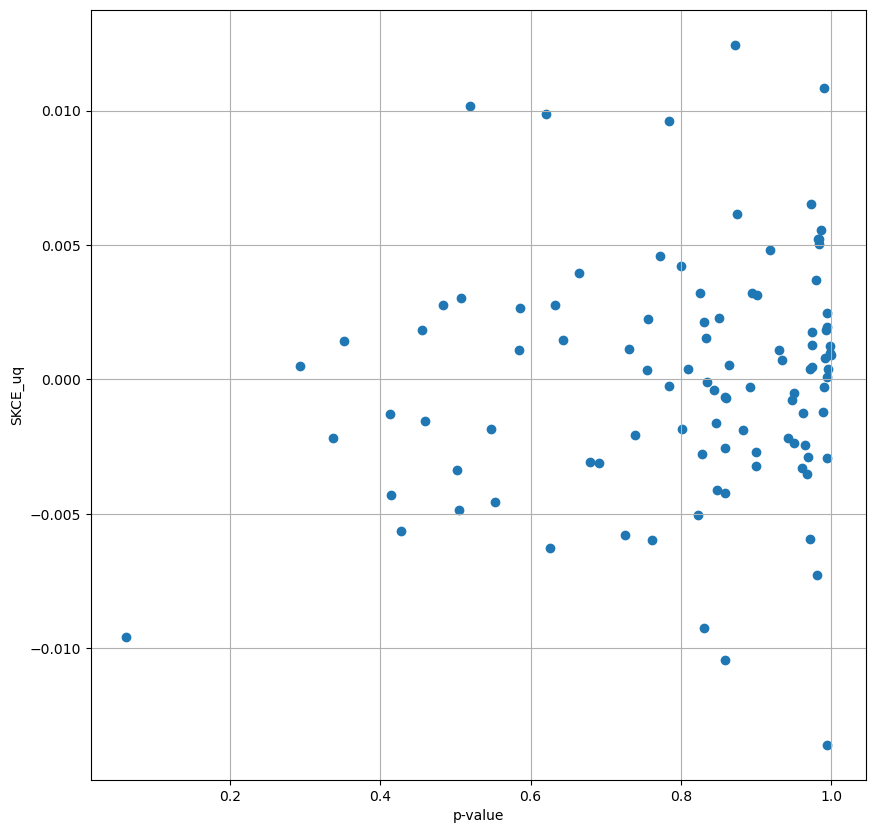

In [47]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(result_skceuq[0]["SKCEul"][1, :], result_skceuq[0]["SKCEul"][0, :])
ax.set_xlabel("p-value")
ax.set_ylabel("SKCE_uq")
plt.grid()

